In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score
import keras as k
import pandas as pd
import matplotlib.pyplot as plt

2024-01-29 22:43:33.328455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
subsets = {
    1: [1, 7, 8, 9, 36, 37],
    2: [2, 5, 10, 11, 12, 13, 15, 39, 40, 41, 42, 44, 38, 65],
    3: [3, 6, 14, 16, 17, 19, 20, 43, 45, 46, 48, 49],
    4: [18, 21, 22, 23, 24, 25, 26, 47, 50, 51, 52, 53, 54, 55],
    5: [4, 27, 28, 29, 30, 31, 32, 33, 34, 35, 56, 57, 58, 59, 60, 61, 62, 63, 64],
}

label = "0"
train_df = pd.DataFrame(columns=['path', 'label'])
for i in subsets[1] + subsets[3] + subsets[4] + subsets[5]:
    new_df = pd.DataFrame({'path': ['YaleB/B01P00/' + str(i) + '.tif'], 'label': [label]})
    train_df = pd.concat([train_df, new_df], ignore_index=True)

label = "1"
for i in subsets[1] + subsets[3] + subsets[4] + subsets[5]:
    new_df = pd.DataFrame({'path': ['YaleB/B02P00/' + str(i) + '.tif'], 'label': [label]})
    train_df = pd.concat([train_df, new_df], ignore_index=True)



label = "0"
test_df = pd.DataFrame(columns=['path', 'label'])
for i in subsets[2]:
    new_df = pd.DataFrame({'path': ['YaleB/B01P00/' + str(i) + '.tif'], 'label': [label]})
    test_df = pd.concat([test_df, new_df], ignore_index=True)

label = "1"
for i in subsets[2]:
    new_df = pd.DataFrame({'path': ['YaleB/B02P00/' + str(i) + '.tif'], 'label': [label]})
    test_df = pd.concat([test_df, new_df], ignore_index=True)

In [3]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Sharpening
    shear_range=0.2,
    zoom_range=0.2,
    # Flipping
    horizontal_flip=True,
    vertical_flip=True,
)

training_set = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./",
    x_col="path",
    y_col="label",
    target_size=(160, 160),
    batch_size=8,
    class_mode="binary",
)

test_datagen = ImageDataGenerator()

test_set = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./",
    x_col="path",
    y_col="label",
    target_size=(160, 160),
    batch_size=8,
    class_mode="binary",
)

Found 102 validated image filenames belonging to 2 classes.
Found 28 validated image filenames belonging to 2 classes.


In [4]:
cnn = k.models.Sequential()

cnn.add(k.layers.Conv2D(filters=16, kernel_size=3, input_shape=[160, 160, 3], kernel_regularizer=k.regularizers.l2(0.001)))
cnn.add(k.layers.BatchNormalization())
cnn.add(k.layers.Activation("relu"))
cnn.add(k.layers.MaxPool2D(pool_size=4, strides=4))

cnn.add(k.layers.Conv2D(filters=32, kernel_size=3, kernel_regularizer=k.regularizers.l2(0.001)))
cnn.add(k.layers.BatchNormalization())
cnn.add(k.layers.Activation("relu"))
cnn.add(k.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(k.layers.Conv2D(filters=64, kernel_size=3, kernel_regularizer=k.regularizers.l2(0.001)))
cnn.add(k.layers.BatchNormalization())
cnn.add(k.layers.Activation("relu"))
cnn.add(k.layers.AveragePooling2D(pool_size=2, strides=2))

cnn.add(k.layers.Flatten())

cnn.add(k.layers.Dense(units=256, kernel_regularizer=k.regularizers.l2(0.001), activation="relu"))
cnn.add(k.layers.Dense(units=148, kernel_regularizer=k.regularizers.l2(0.001)))
cnn.add(k.layers.Dense(units=1, kernel_regularizer=k.regularizers.l2(0.001), activation="sigmoid"))

cnn.compile(
    optimizer=k.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [5]:
# train
history = cnn.fit(x=training_set, validation_data=test_set, epochs=50, batch_size=8)


Epoch 1/50
13/13 [==============================] - 3s 110ms/step - loss: 2.0401 - accuracy: 0.4902 - val_loss: 2.3323 - val_accuracy: 0.5000
Epoch 2/50
13/13 [==============================] - 1s 109ms/step - loss: 1.4952 - accuracy: 0.4902 - val_loss: 1.3928 - val_accuracy: 0.4286
Epoch 3/50
13/13 [==============================] - 2s 118ms/step - loss: 1.3666 - accuracy: 0.4804 - val_loss: 1.2861 - val_accuracy: 0.4286
Epoch 4/50
13/13 [==============================] - 2s 124ms/step - loss: 1.3184 - accuracy: 0.5490 - val_loss: 1.3296 - val_accuracy: 0.5000
Epoch 5/50
13/13 [==============================] - 1s 98ms/step - loss: 1.2832 - accuracy: 0.5098 - val_loss: 1.2995 - val_accuracy: 0.5714
Epoch 6/50
13/13 [==============================] - 1s 92ms/step - loss: 1.2611 - accuracy: 0.5294 - val_loss: 1.2277 - val_accuracy: 0.5000
Epoch 7/50
13/13 [==============================] - 1s 92ms/step - loss: 1.1861 - accuracy: 0.5784 - val_loss: 1.3120 - val_accuracy: 0.5000
Epoch 8/5

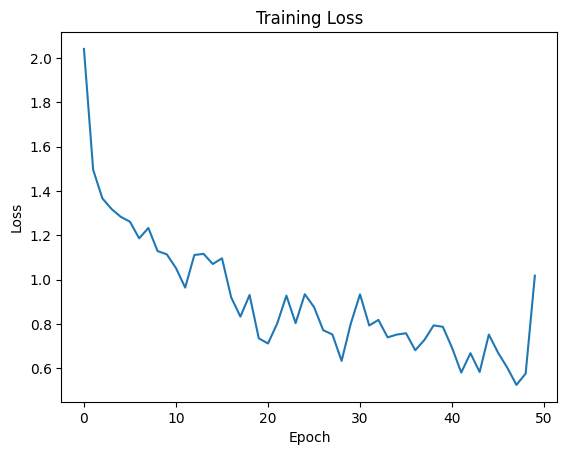

In [6]:
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(history.history["loss"])
plt.show()

In [7]:
# f1 and accuracy
y_pred = cnn.predict(test_set)
y_pred = (y_pred > 0.5)
y_pred = y_pred.astype(int)
y_true = test_set.classes
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("F1: ", f1_score(y_true, y_pred))


4/4 [==============================] - 0s 20ms/step
Accuracy:  0.5357142857142857
F1:  0.43478260869565216
